In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn import preprocessing
import importlib
import gomokutrainer
import onnx
import keras2onnx
import matplotlib.pyplot as plt
from os import path
from datetime import datetime


data_train_x_board (48612) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_train_x_turn (48612) 
 [[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
data_train_y (48612) 
 [[-0.93096608]
 [-0.92133956]
 [-0.9239152 ]
 ...
 [ 0.93747573]
 [ 0.93457395]
 [ 0.93296746]]
data_validation_x_board (2559) 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data_validation_x_turn (2559) 
 [[-1]
 [-1]
 [-1]
 ...
 [ 1]
 [ 1]
 [ 1]]
data_validation_y (2559) 
 [[-0.93441971]
 [-0.91117307]
 [-0.91056099]
 ...
 [ 0.90341977]
 [ 0.91636798]
 [ 0.92701279]]


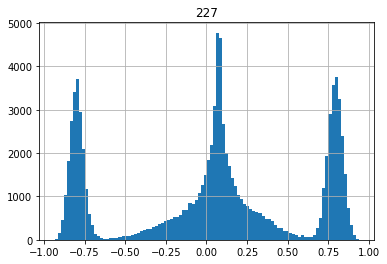

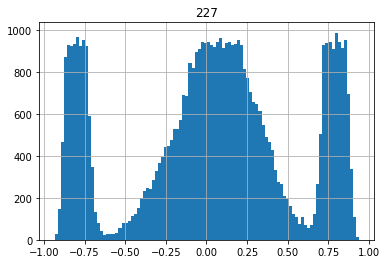

In [2]:
data_raw = pd.concat([
    #pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v2_2021-05-05_09-26-20.csv", header=None, sep=';', decimal=","),
    #pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\v2_I30000_MEC1000_05-06_10-36-25.csv", header=None, sep=';', decimal=","),
    #pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\I30000_MEC1000_05-21_13-05-06.csv", header=None, sep=';', decimal=",")
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\I5000_05-21_17-51-38.csv", header=None, sep=';', decimal=","),
    pd.read_csv("C:\\Projects\\TrainDatasetGenerator\\I5000_05-21_17-52-16.csv", header=None, sep=';', decimal=",")
], ignore_index = True)
input_slice = range(225)
##Reverse first player evaluations
#print("before \n", data_raw[lambda x: x[450] == 1])
data_raw = data_raw[(data_raw[227] != 1) & (data_raw[227] != -1)].reset_index(drop = True)
#data_raw.loc[lambda x: x[225] == 1,227] = data_raw.loc[lambda x: x[225] == 1,227].apply(lambda x: x*-1)
#data_raw.loc[lambda x: x[225] == 1,input_slice] = data_raw.loc[lambda x: x[225] == 1,input_slice].apply(lambda x: x*-1)
#print("after \n", data_raw[lambda x: x[450] == 1])

data_raw.hist(column=227, bins=100)

data_raw["class"] = data_raw[227] // 0.01

#data_raw.hist(column="class", bins=100)

max_class_count = 500

data_raw = data_raw.groupby("class").apply(lambda x: x.sample(max_class_count if len(x) > max_class_count else len(x) )).reset_index(drop=True)
#data_raw.hist(column="class", bins=100)
data_raw.hist(column=227, bins=100)

data_train = data_raw[data_raw.index % 20 != 0].reset_index(drop = True)
data_validation = data_raw[data_raw.index % 20 == 0].reset_index(drop = True)

data_train_x_board = data_train[input_slice].to_numpy()
data_train_x_turn = data_train[225].to_numpy().reshape((-1,1))
data_validation_x_board = data_validation[input_slice].to_numpy() 
data_validation_x_turn = data_validation[225].to_numpy().reshape((-1,1))

data_train_y = data_train[[227]].to_numpy()
data_validation_y = data_validation[[227]].to_numpy()


print(f"data_train_x_board ({len(data_train_x_board)}) \n", data_train_x_board)
print(f"data_train_x_turn ({len(data_train_x_turn)}) \n", data_train_x_turn)
print(f"data_train_y ({len(data_train_y)}) \n", data_train_y)
print(f"data_validation_x_board ({len(data_validation_x_board)}) \n", data_validation_x_board)
print(f"data_validation_x_turn ({len(data_validation_x_turn)}) \n", data_validation_x_turn)
print(f"data_validation_y ({len(data_validation_y)}) \n", data_validation_y)

#print(data_train_x[100])
#print(data_train_y[100])

In [3]:

input_shape = (15,15,1)
input_len = input_shape[0] * input_shape[1] * input_shape[2]

# Ieejas slānis A
inputA = keras.Input(shape=input_len, name="input_board")
# Ieejas slānis B
inputB = keras.Input(shape=1, name="input_turn")
# Transformācijas slānis 1D -> 2D
a = layers.Reshape(input_shape)(inputA)
# 1.Konvolūciju slānis
a = layers.Conv2D(32, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
# Aktivizācijas slānis
a = layers.LeakyReLU(alpha=0.2)(a)
# 2. Konvolūciju slānis
a = layers.Conv2D(64, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
# Aktivizācijas slānis
a = layers.LeakyReLU(alpha=0.2)(a)
# 3. Konvolūciju slānis
a = layers.Conv2D(64, kernel_size=(2, 2), kernel_initializer=keras.initializers.HeNormal())(a)
# Aktivizācijas slānis
a = layers.LeakyReLU(alpha=0.2)(a)
# Transformācijas slānis 2D -> 1D
a = layers.Flatten()(a)
# 1. Pilnsaistes slānis
a = layers.Dense(64, kernel_initializer=keras.initializers.HeNormal())(a)
# Aktivizācijas slānis
a = layers.LeakyReLU(alpha=0.2)(a)
# Konkatenācijas slānis
a = layers.Concatenate()([a, inputB])
# 2. Pilnsaistes slānis
a = layers.Dense(32, kernel_initializer=keras.initializers.HeNormal())(a)
# Aktivizācijas slānis
a = layers.LeakyReLU(alpha=0.2)(a)
# Izejas slānis ar aktivizācijas funkciju ‘tanh’
a = layers.Dense(1, activation='tanh', name="output")(a)

model = keras.Model(inputs=[inputA,inputB], outputs=a)

model.compile(tf.optimizers.RMSprop(), loss='mse')
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_board (InputLayer)        [(None, 225)]        0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 15, 15, 1)    0           input_board[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   160         reshape[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 32)   0           conv2d[0][0]                     
_______________________________________________________________________________________

In [4]:
history = model.fit([data_train_x_board,data_train_x_turn], data_train_y, epochs=30, 
    validation_data=([data_validation_x_board,data_validation_x_turn], data_validation_y))

#predictions = model.predict(data_validation_x)

Epoch 1/30
1520/1520 [==============================] - 25s 17ms/step - loss: 0.1433 - val_loss: 0.1260
Epoch 2/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0860 - val_loss: 0.1229
Epoch 3/30
1520/1520 [==============================] - 25s 17ms/step - loss: 0.0682 - val_loss: 0.0978
Epoch 4/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0566 - val_loss: 0.0876
Epoch 5/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0494 - val_loss: 0.0620
Epoch 6/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0437 - val_loss: 0.0567
Epoch 7/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0398 - val_loss: 0.0556
Epoch 8/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0364 - val_loss: 0.0537
Epoch 9/30
1520/1520 [==============================] - 26s 17ms/step - loss: 0.0337 - val_loss: 0.0517
Epoch 10/30
1520/1520 [==============================] - 26s 17m

minimal validation loss = 0.03589276969432831


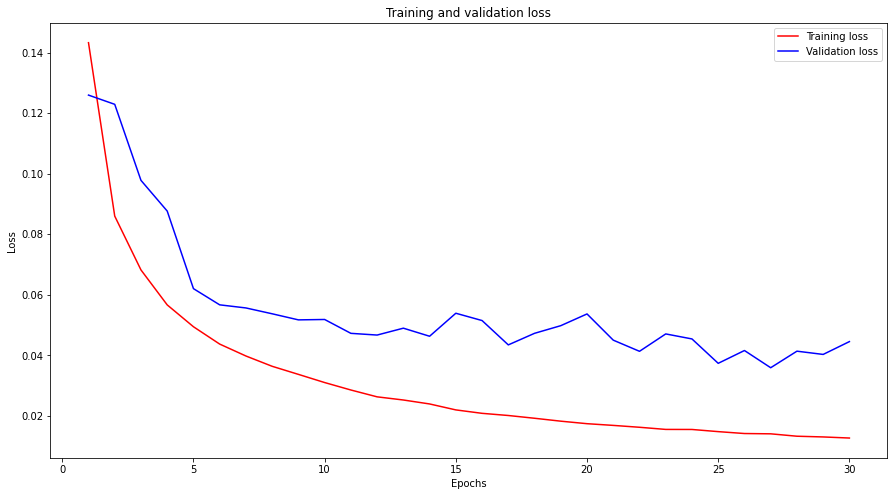

In [5]:

history.history.keys()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,8))
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

print(f'minimal validation loss = {min(val_loss)}' )

In [16]:
output_path = path.join("C:\\","Projects","TrainDatasetGenerator","TrainedModels", datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
model.save(path.join(output_path,"keras-model"))
onnx_model = keras2onnx.convert_keras(model, "model.onnx")
onnx.save_model(onnx_model, path.join(output_path, "model.onnx"))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Projects\TrainDatasetGenerator\TrainedModels\2021-05-20_09-54-03\keras-model\assets
tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 36 -> 20
The maximum opset needed by this model is only 11.


In [8]:

def draw_board(arr): 
    BOARD_SIZE = 15
    s = ""
    for row in range(BOARD_SIZE):
        if(BOARD_SIZE - row < 10):
            s += ' '
        s += str(BOARD_SIZE - row)
        for column in range(BOARD_SIZE):
            cell = arr[row * BOARD_SIZE + column]
            if(cell == 0):
                s += ' '
            elif(cell == 1):
                s += 'x'
            elif(cell == -1):
                s += 'o'
            else:
                raise Exception("Error")
            
            
        
        s += '\n'
    
    s += '  '
    for column in range(BOARD_SIZE):
        s += chr(65 + column)
    return s
        

In [37]:
s = slice(38110,38120)
samples_board = data_train_x_board[s]
samples_turn = data_train_x_turn[s]
samples_eval = data_train_y[s]
predictions = model.predict([samples_board, samples_turn])
for i in range(len(predictions)):
    print(draw_board(samples_board[i]))
    print("turn:", samples_turn[i])
    print("prediction:", predictions[i])
    print("expected:", samples_eval[i])
    print("\n")

15               
14      x        
13     xo    x   
12      o   o    
11    x ooxo     
10     oxxoxo    
 9      ooxox o  
 8      xoxxxxo  
 7       xo x    
 6         x oo  
 5        x      
 4       o       
 3               
 2               
 1               
  ABCDEFGHIJKLMNO
turn: [1]
prediction: [0.49423885]
expected: [0.48727615]


15               
14               
13     x         
12     o  x      
11    ooox       
10     ox        
 9    oxxo       
 8     o xo      
 7        xx     
 6         x     
 5          o    
 4               
 3               
 2               
 1               
  ABCDEFGHIJKLMNO
turn: [1]
prediction: [0.53271127]
expected: [0.48425787]


15               
14               
13               
12           o   
11      o   x    
10   oo  x xx    
 9     xoox      
 8     oxxoxx    
 7      o   x    
 6           o   
 5            o  
 4               
 3               
 2               
 1               
  ABCDEFGHIJKLMNO
turn: [1]
predic